### Creating and testing magnetic dipoles and grid system

In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import time

from Modules.muon import Muon
from Modules.positron import Positron
import Modules.functions as func

from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit

# Setting graph defaults to avoid repetition on each plot
mpl.rcParams["axes.formatter.limits"] = -2, 2  # Sets xticks to use exponents
mpl.rcParams["axes.grid"] = True  # Turns grid on
mpl.rcParams["legend.loc"] = "best"  # Turns legend on and autoplaces it

### Dipole class
Creates a dipole of some strength, with a given orientation and location
The magnetic moment "m" is calculated by:
$m = [r cos(\theta), r sin(\theta)]$<br>
Where $r$ is the strength and $\theta$ is the angle from the x axis<br>

The method "get_mag_field()" returns the magnetic field due to the dipole at a given point in space.

In [24]:
class Dipole(object):
    """
    Creates dipole:
    location = (pos_x, pos_y)
    orientation and length = pole_separation
    """
    count = 0
    def __init__(self, orientation, location, strength):
        """
        Init object: orientation (degrees), location (array), strength (scalar in Tesla)
        """
        self.location = np.array(location)
        self.orientation_d = orientation
        self.orientation_r = np.deg2rad(orientation)
        self.strength = strength
        self.moment = np.array([strength * np.cos(self.orientation_r), strength * np.sin(self.orientation_r), 0])
        Dipole.count += 1

    def __repr__(self):
        """Sets string representation of the instance"""
        return ("Dipole object:  Location: {}\n\
                Orientation: {:.2f} degrees\n\
                Strength: {:.3e} T\n\
                Moment: {}".format(self.location, self.orientation_d, self.strength, self.moment))

    def get_mag_field(self, target):
        """Gets magnetic field at target location (x, y, z)"""
        # Check that coordinates are same dimension
        if not len(target)==len(self.location):
            raise ValueError("Target location and dipole location must be given in the same dimensions")
        mag_perm = 4*np.pi*10**-7  # Cancel constant terms to get mag_perm as only constant
        relative_loc = np.subtract(np.array(target), self.location)
        magnitude = get_mag(relative_loc)
        return (mag_perm/4*np.pi) * (
                (3*relative_loc*(np.dot(self.moment, relative_loc)) / (magnitude**5))
                - (self.moment / (magnitude**3))
                )

    def get_relative_loc(self, other):
        return other.location - self.location


### Grid class (WiP)
Creates a grid into which the dipoles can be placed


In [44]:
class Grid(object):
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.add_points(width, height)
    
    def __repr__(self):
        #widthheight = f"Width: {self.width}, Height: {self.height}"
        #rowscols = f"x points: {self.cols}, y points: {self.rows}"
        #return widthheight + "\n" + rowscols
        return str(self.points)
    
    def add_points(self, x_points, y_points):
        self.cols = np.linspace(0, self.width, x_points)
        self.rows = np.linspace(0, self.height, y_points)
        self.points = np.zeros([x_points, y_points], dtype=object)
    
    def change_point(self, location, value):
        x, y = location
        self.points[self.height-y][x] = value

g = Grid(10, 10)
#g.add_points(3, 3)
g.change_point([0, 2], "x")
print(g)

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 ['x' 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


### General functions

In [26]:
def set_unit(vector):
    norm = np.linalg.norm(vector)
    if norm == 0: 
       return vector
    return vector / norm

def get_mag(vector):
    return np.sqrt(vector.dot(vector))

def set_dir_2d(vector):
    return np.arctan(vector[1]/vector[0])

In [27]:
def set_field_values(x_array, y_array, dipole_dict, resolution=10):
    # Loop over points in grid and get field at each point
    field_x = np.zeros([len(x_array), len(y_array)])
    field_y = np.zeros_like(field_x)
    try:
        for i, x in enumerate(x_array[::resolution]):
            for j, y in enumerate(y_array[::resolution]):
                for coord, dipole in dipole_dict.items():
                    field_at_point = dipole.get_mag_field(target=[x, y, 100e-6])
                    field_x[i][j] += field_at_point[0]
                    field_y[i][j] += field_at_point[1]
    # Catches errors without crashing
    except TypeError as e:
        print("======ERROR======")
        print("i, x", i, x)
        print("j, y", j, y)
        print(field_at_point)
        raise
    return field_x, field_y

### Function to create the dipole grid

In [28]:
def create_dipole_grid(x_array, y_array, strength=1e-3, dipole_spacing=40, buffer=20, random_angle=False):
    """
    Creates a grid of dipoles
    Places a dipole every {dipole_spacing} on the x/y array with a buffer around the edges
    """
    start = time.time()
    dipole_dict = {}
    angle = 0
    for x in x_array[buffer:-buffer:dipole_spacing]:
        for y in y_array[buffer:-buffer:dipole_spacing]:
            if random_angle:
                angle = np.random.randint(0, 361)
            dipole_dict["{}, {}".format(x, y)] = Dipole(orientation=angle,
                                                        location=[x, y, 0],
                                                        strength=strength)
    print("Made all dipoles")
    # Creating grids to store the field values and directions
    field_x, field_y = set_field_values(x_array, y_array, dipole_dict, resolution=20)
    
    end = time.time()
    time_taken = end-start
    print("Made {} dipoles in {}s".format(Dipole.count, time_taken))
    
    # Clear dipole count for next iteration
    Dipole.count = 0
    
    return dipole_dict, field_x, field_y

##### Creating dipole grids
Aligned and random orientations

In [29]:
Nx, Ny = 100, 100
side_length = 2e-3
x_array = np.linspace(-side_length, side_length, Nx)
y_array = np.linspace(-side_length, side_length, Ny)

dipoles_aligned, field_x_aligned, field_y_aligned = create_dipole_grid(x_array, y_array,
                                                      dipole_spacing=50, random_angle=False,
                                                        strength=1e-2, buffer=0)
dipoles_random,field_x_random, field_y_random = create_dipole_grid(x_array, y_array,
                                                    dipole_spacing=50, random_angle=True,
                                                        strength=1e-2, buffer=0)

Made all dipoles
Made 0 dipoles in 0.0006575584411621094s
Made all dipoles
Made 0 dipoles in 0.0004115104675292969s


##### Calculating field strength for all points in grid

In [30]:
strength_aligned = np.zeros_like(field_x_aligned)
strength_aligned += np.sqrt(field_x_aligned**2 + field_y_aligned**2)

strength_random = np.zeros_like(field_x_aligned)
strength_random += np.sqrt(field_x_random**2 + field_y_random**2)

In [31]:
plt.figure()


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

### Plotting the field lines

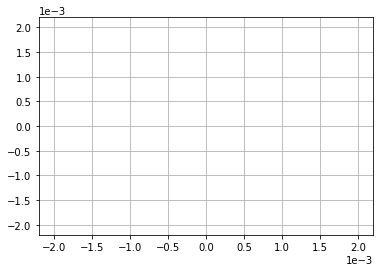

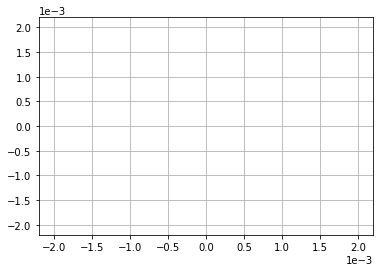

In [32]:
fig1, ax1 = plt.subplots(1, 1, sharey=True)
fig2, ax2 = plt.subplots(1, 1, sharey=True)

# STREAMPLOT
aligned = ax1.streamplot(x_array, y_array,
               field_y_aligned, field_x_aligned,
               density=3)


random = ax2.streamplot(x_array, y_array, field_y_random, field_x_random,
               density=3)

# DIRECTIONAL ARROW SHOWING DIPOLE
for coord, dip in dipoles_aligned.items():
    x, y = dip.location[1], dip.location[0]
    angle = dip.orientation_d + 90
    ax1.quiver(x, y, dip.moment[1]*2, dip.moment[0]*2,
               angles=angle, color="r", alpha=0.7)
    
for coord, dip in dipoles_random.items():
    x, y = dip.location[1], dip.location[0]
    angle = dip.orientation_d + 90
    ax2.quiver(x, y, dip.moment[1]*2, dip.moment[0]*2,
               angles=angle, color="r", alpha=0.7)

# SETTING PLOT SIZE AND FORMAT
ax1.set_xlim(-side_length-(side_length/10), side_length+(side_length/10))
ax1.set_ylim(-side_length-(side_length/10), side_length+(side_length/10))
ax2.set_xlim(-side_length-(side_length/10), side_length+(side_length/10))
ax2.set_ylim(-side_length-(side_length/10), side_length+(side_length/10))
plt.show()

In [33]:
plt.figure()
plt.imshow(strength_aligned, cmap="hot", norm=colors.LogNorm(vmin=strength_aligned.min(),vmax=strength_aligned.max()))

plt.figure()
plt.imshow(strength_random, cmap="hot", norm=colors.LogNorm(vmin=strength_random.min(),vmax=strength_random.max()))

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f046adf8f80> (for post_execute):


ValueError: values must all be positive